# EPOCH Warming Up Session_1주차 (송태원)
# 연습 문제12.
> 사이킷런을 사용하지 않고 넘파이만 사용하여 조기 종료를 사용한 배치 경사 하강법으로 소프트맥스 회귀를 구현해보세요. 이를 붓꽃 데이터셋 같은 분류 작업에 사용해보세요.



- numpy만 사용해야 함 (사이킷런 사용X)
- 소프트맥스 회귀
- 근데 이제 조기 종료를 사용한 배치 경사 하강법을 곁들인.
- 분류 작업에 활용해보기

## 1. 데이터셋 세팅

iris 데이터셋을 재사용하자

In [1]:
from sklearn import datasets
import pandas as pd
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [2]:
import numpy as np

In [3]:
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 넓이
y = iris["target"]

아래 코드처럼 X 샘플 별로 [꽃잎 길이, 꽃잎 넓이] 특징만 잘출력되고 있음

In [4]:
X[:5]

array([[1.4, 0.2],
       [1.4, 0.2],
       [1.3, 0.2],
       [1.5, 0.2],
       [1.4, 0.2]])

타깃값 `y` 확인
* setosa = 0
* versicolur= 1
* virginica = 2

In [6]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

**데이터에 편향을 추가해주도록 한다.**
편향이 없으면?



*   만약 편향을 추가하지 않으면, 모델의 예측 값은 항상 원점을 지나가야 한다
*   𝑥=0일 때 항상 𝑦=0
*   하지만 실제 데이터에서는 그런 경우가 많지 않음.
*   e.g. 예시로, 키와 몸무게의 관계를 예측할 때, 키가 0cm일 때 몸무게도 0kg이어야 할


In [13]:
ts = np.ones(len(X))
# print(ts)

X_with_bias = np.c_[np.ones(len(X)), X]

# len(X) 길이만큼 1로 구성된 배열 생성 -> [1, 1, 1, 1, 1, ...]
# np.c_를 통해 입력값 X와 합쳐줌

150



*  `np_c[]`: 어레이를 좌우로 이어붙이기
*   `np.ones()`: 1로 구성된 어레이 생성. 인자는 생성되는 어레이 모양(shape)

In [14]:
# 각 입력값마다 편향(1)이 예쁘게 추가된 걸 확인할 수 있음
# before: [1.4, 0.2]
# after: [1, 1.4, 0.2]

X_with_bias[:5]

array([[1. , 1.4, 0.2],
       [1. , 1.4, 0.2],
       [1. , 1.3, 0.2],
       [1. , 1.5, 0.2],
       [1. , 1.4, 0.2]])

훈련셋, 검증셋, 테스트셋 비율 나누기

sklearn에서는 train_split으로 딸칵 가능하지만 직접 해본다..

In [15]:
test_ratio = 0.2  # 테스트셋 - 20%
validation_ratio = 0.2   # 검증셋 20%

total_size = len(X_with_bias) # 전체 입력 데이터셋 크기 = 150
print(total_size)

test_size = int(total_size * test_ratio)              # 테스트셋 크기 - 150*0.2 = 30
validation_size = int(total_size * validation_ratio)  # 검증셋 크기 - 150*0.2 = 30
train_size = total_size - test_size - validation_size # 훈련셋 크기 - 나머지인 60% - 150*0.6 = 90

print(test_size, validation_size, train_size)

150
30 30 90


이제 위 크기에 따라 실제 데이터셋을 나누기 전, 전체 데이터셋을 한 번 뒤섞어 주는 작업을 해줘야 한다고.

In [17]:
np.random.seed(2025)
# random 난수값 고정하여, random 라이브러리 사용 시 계속해서 값이 바뀌지는 않도록 고정

random_mix = np.random.permutation(total_size)

> 여기서 permutation은 순열을 의미!

우리가 익히 알고 있는 `순열/조합`의 그 순열이 맞고,

total_size 크기만큼 순열을 뽑아서 일렬로 나열한다는 의미, 그렇게 추출된 순서(인덱스)가 random_mix에 저장

In [19]:
random_mix

# 총 데이터 크기인 150에 맞추어서 0~150까지의 순열 완성 -> 얘가 곧 데이터셋을 섞기 위한 순서(인덱스)가 될 것

array([  2, 148, 112, 132,   0, 113,  34,  51, 135,   5, 121,  83,  23,
       137,  43,  20,   1,  44,  78, 134,  26,  70,  47,   4,  46,  54,
        19, 109, 114, 105, 128, 104,  91,  57, 123,  80, 129, 100,  37,
         8,  88,  29,  58,  84,  89, 147,   6,  49,   7,  99, 131, 136,
        77, 107,  30,  11,  48, 142,  93,  35,  14,  74,  81, 143,  66,
        96,  39,  63, 108,  65, 103,  98,  12,  87,  60, 138,  82,  86,
       146,  75,  38,  28,  68, 144, 130,  16,  59, 125, 110,  32,   9,
        18,  61,  21,  25,  15,  72,  50, 122,  24,  45, 141, 102,  71,
        56, 139, 149, 120,  55,  17, 118, 116,  85,  69, 133,  95,  52,
        31,  92, 126, 145,  53,  79, 127,  42,  36, 124, 106,  41,  90,
       115,  13,  27,  73,  33, 119,   3, 117,  64, 111, 101,  40,  97,
        10,  22, 140,  67,  76,  94,  62])

In [20]:
# 훈련셋
X_train = X_with_bias[random_mix[:train_size]]
y_train = y[random_mix[:train_size]]

# 검증셋
X_valid = X_with_bias[random_mix[train_size:-test_size]]
y_valid = y[random_mix[train_size:-test_size]]

# 테스트셋
X_test = X_with_bias[random_mix[-test_size:]]
y_test = y[random_mix[-test_size:]]

### 타깃값 바꿔주기

아까 print 해보았듯이 현재 타깃 클래스 형태는 이러함

`(0, 1, 2)  -> (setosa, versicolur, virginica)`


소프트맥스 회귀 모델을 훈련시키기 위해 필요한 것은 이 새로운 x샘플이 셋 중 어느 타깃 클래스에 속하는지를 분류하는 것..!

즉, 3개의 각 타깃 클래스별로 확률값이 필요하다!

e.g. 새로운 샘플 x가..


*   `setosa` 꽃일 확률 (0~1)
*   `versicolur` 꽃일 확률 (0~1)
*   `virginica` 꽃일 확률 (0~1)

```
[0.9, 0.01, 0.09]
```

즉, `setosa` 꽃으로 잘분류하려면 위처럼 0번 인덱스의 값이 가장 크고, 나머지는 거의 0에 가깝게 작게 확률값이 나와야 함


* 따라서 확률 예측값(`X*θ`)과 타깃 실제값 사이의 오차를 이용하여 **소프트 맥스 함수**로 비용함수를 계산하려면 원-핫 인코딩으로 데이터  모양을 맞춰줘야 함
* 그냥 y값을 그대로 사용하면 입력값은 소프트맥스 함수를 거쳐서 확률값으로 나올텐데, y값은 '확률'이 아닌 단순히 레이블을 구분하는 '숫자'로 되어 있으니까 올바르지 않음.
* 아래 사진처럼 **소프트 맥스 회귀** 자체가 다중 클래스를 분류할 수 있도록 다중 클래스의 확률값을 구하는 함수니까!
* (소프트맥스 함수 자세 개념은 교재 참조)



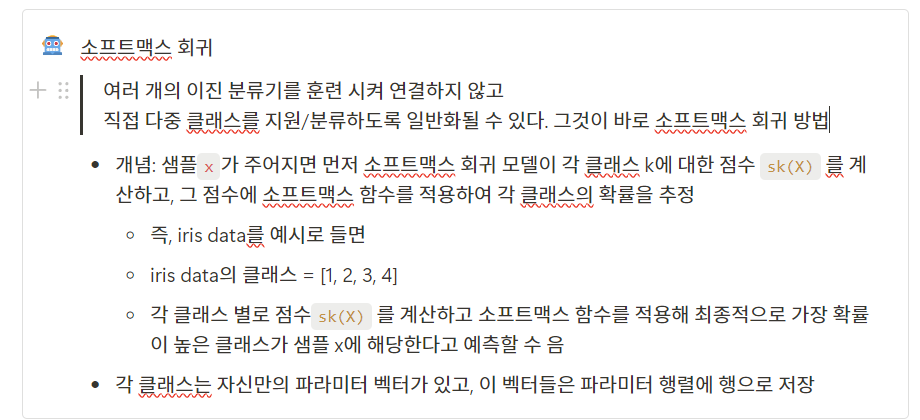

In [33]:
def one_hot(y): # 타깃값이 y를 전처리하는 거니까 y가 들어가주면 되고
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

그럼 이렇게 기존의 타깃값이었던 `y` 가 예쁘게 [확률값, 확률값, 확률값] 형태로 바뀐다.

In [34]:
one_hot(y_train[:10])

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

그럼 동일하게 아까 나누었던 테스트, 검증, 훈련셋에 대해서도 원-핫 인코딩을 쭉 해주면 되겠네

In [35]:
Y_train_one_hot = one_hot(y_train)
Y_valid_one_hot = one_hot(y_valid)
Y_test_one_hot = one_hot(y_test)

In [36]:
Y_train_one_hot.shape

(90, 3)

150 중에 90 (=60%) 문제없고

## 2. 소프트맥스 함수 구현
이제 찐으로 x 샘플이 특정 꽃 품종(클래스)에 속할 확률을 계산하기 위해 소프트맥스 점수를 계산해주기만 하면 끝일 듯..? (아마)




### a. 자세한 "소프트맥수 점수" 계산 방식은 교재의 **행렬 연산 표기법**을 잘이해하기만 하면 됨,
* 다만 다중 클래스 분류이기 때문에 벡터값이 `(n+1)*(타깃 클래스 개수)` 형태로 표현될 것
* 그리고 아직 점수 형태이지 확률처럼 해석되지는 않음

### b.이제 소프트맥수 점수 -> 확률

* 해주는 과정이 필요한 것
* 그 과정에서 아래 사진과 같은 함수 적용을 해주는 것!!

즉, 소프트맥스 함수의 핵심은 ***지수 함수(exp)***를 적용해서 점수를 변형하는 것

소프트맥스 함수는 각 점수를 지수 함수로 변형한 후, 그 값들의 합으로 나누어 확률로 변환

```
여기서
exp(𝑠𝑘(𝑥)라는 것은 지수 함수(e^x, 즉 자연로그의 밑 e를 거듭제곱한 것)를 의미
```

1. 각 점수에 대해 지수 함수(exp)를 적용
2. 그 값들의 합을 계산
3. 각 점수를 합으로 나누어 확률로 변환


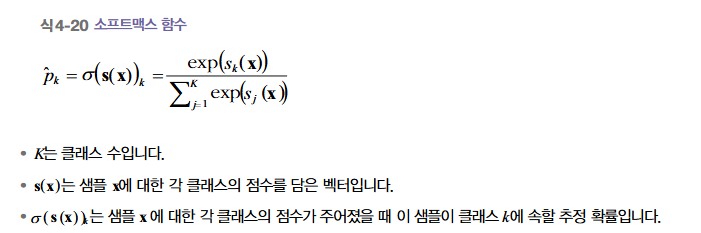

> 왜 지수 함수를 적용하는데?
* 점수를 0보다 큰 값으로 변환하기 위해
* 점수 차이가 클수록, 확률 차이를 더 명확하게 하기 위해

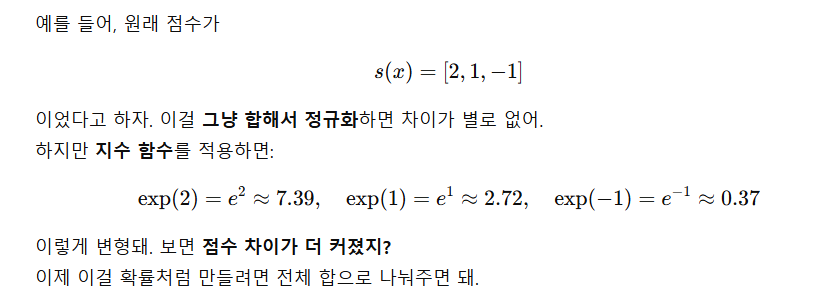

> 우리의 문제에서는..?
* `K`: 클래스 수 3개 -> 꽃 종류 3개니까
* `s(x)`: 실제 타깃 값 클래스별 확률 [0.9, 0.01, 0.09] 뭐 이렇게 되어있으면 클래스 0이라는 말
* 예시로 보면 더 잘이해됨


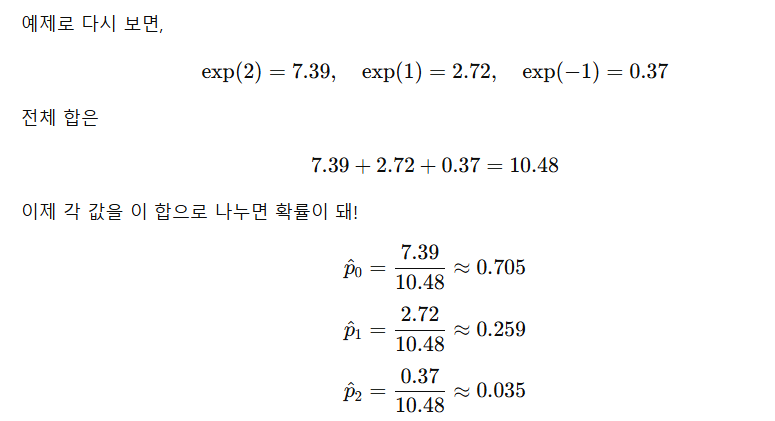

> 원리를 이해했으니, 이제 책에 내가 할 일? 교재에 나와있는 소프트맥수 함수 그대로 코드화 해준 것 뿐..

함수 어떻게 코드화하는지는 책보고 구글링을 참고했다,,,

외우고 다니면 ㅇㅈ

* `logits`: 모든 샘플에 대한 소프트맥스 점수로 구성된 (m, K) 모양의 어레이.
* `m`은 샘플 수
* 반환값은 `s(X)`

In [37]:
def softmax(logits):
    exps = np.exp(logits) # 분자
    exp_sums = np.sum(exps, axis=1, keepdims=True) # 분모
    return exps / exp_sums

💡 결론
* 소프트맥스는 입력값을 확률로 변환하는 함수
* `exp(지수함수)`로 큰 값은 더 커지고, 작은 값은 더 작아지게 함.
* 클래스 분류 문제에서 가장 가능성 높은 클래스를 선택하는 데 유용
* 가장 큰 확률을 가진 클래스는 어떻게 고르는데? ->  **`np.argmax()`**를 이용해 선택!

## 3. 모델 훈련



> 이제 앞서 작성한 소프트맥스 함수를 활용해 모델 훈련시켜주고 결과



거의 다 한 듯..?
입력과 출력의 개수를 정의

In [38]:
n_inputs = X_train.shape[1] # (특성 2개 + 편향 1개 = 3개)
n_outputs = len(np.unique(y_train))   # (3개의 붓꽃 클래스), unique로 3개 뽑아주면 되고~

### 소프트맥스 회귀의 비용 함수

* 크로스 엔트로피cross entropy를 비용 함수로 사용
* 선형 회귀처럼 경사 하강법을 적용해 비용을 최소화하는 최적의 가중치 값을 찾으면 됨 (단, 분류 클래스가 2개가 아니라, 여러 개니까 조금 더 복잡해 보일 뿐)
* **배치 경사하강법 적용 과정을 구현하기 위해 비용 함수와 비용 함수의 그레이디언트 벡터 정의**

```
크로스 엔트로피 손실 함수
```

뭔데?
* 모델이 예측한 확률 분포와 실제 정답 분포가 얼마나 다른지를 측정하는 함수!
* 값이 작을수록 모델이 잘 예측하고 있는 것!

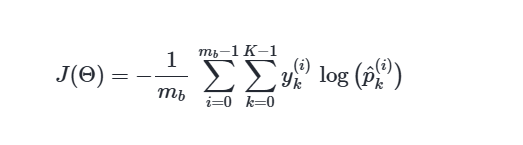

* 여기까지는 수식 이해까지 딥하게는 못함ㅠ,ㅠ 일단 수식이 나와있으니 코드화만 해주기로~

In [39]:
eta = 0.01 # 학습률
n_iterations = 5001 # 에폭
m = len(X_train) # 훈련 데이터 개수
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs) # 가중치 초기화

# 경사 하강법 반복 학습
for iteration in range(n_iterations):
    logits = X_train.dot(Theta) # 훈련 데이터 X_train에 가중치 Theta를 곱해서 클래스별 점수(로짓, logits)를 계산
    Y_proba = softmax(logits) # 이 점수를 아까 위에서 정의했던 소프트맥스 함수로 점수 -> 확률로 변환
    if iteration % 500 == 0:
        loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1)) # 크로스 엔트로피 손실 함수 코드화한거임
        print(iteration, loss)
    error = Y_proba - Y_train_one_hot # 예측값-실제값 = 에러
    gradients = 1/m * X_train.T.dot(error) # 경사하강법 적용!, 위 교재 실습에서 했던 구조 그대로 가져옴
    Theta = Theta - eta * gradients # 손실이 줄어드는 방향으로 가중치 업데이트

0 7.046742202103173
500 1.0445223288561862
1000 0.7946928153528547
1500 0.6555459714282684
2000 0.5746796827832793
2500 0.5226604217246049
3000 0.4859433084383638
3500 0.4581309253826109
4000 0.4359491093905641
4500 0.4175781222235931
5000 0.4019306787715503


전체 흐름을 다시 보면:

1️⃣ 초기 가중치(Theta) 설정

2️⃣ 훈련 데이터로 예측값 계산

3️⃣ 손실 함수(크로스 엔트로피) 계산

4️⃣ 오차(Error) 계산

5️⃣ 경사(Gradient) 계산

6️⃣ 가중치 업데이트 (경사 하강법 적용)

7️⃣ 500번마다 손실값 출력

8️⃣ 반복하면서 모델이 점점 최적의 가중치를 찾음

결국 이 과정이 끝나면 최적의 Theta 값을 얻게 되고,
새로운 입력 데이터에 대해 가장 적절한 클래스 예측 확률을 출력할 수 있게 되는 것

> 파라미터 `Theta` (가중치) 확인

* 소프트맥스 회귀(다중 클래스 로지스틱 회귀)에서 Theta 행렬은 각 클래스별로 학습된 가중치(weight)들을 의미!!
* 즉, 모델이 입력 데이터[꽃잎 길이, 꽃잎 넓이]를 보고 특정 클래스로 분류할 확률을 예측할 때 사용하는 **계수(가중치)**들

In [42]:
Theta

# 각 클래스의 가중치를 담은 행렬

array([[ 3.00895789, -1.0267475 , -3.36715374],
       [-1.10400798,  0.45476638,  0.38458442],
       [-1.30106838, -1.44051691,  0.31166001]])

* 행 개수(3개) → 3개의 클래스(붓꽃의 세 가지 품종)
* 열 개수(3개) → 2개의 특성(꽃잎 길이, 꽃잎 넓이) + 1개의 편향(bias)
> 즉, 각 행이 "내가 이 클래스에 속할 가능성이 얼마나 되는지"를 계산하는 식을 제공하는 것

검증 세트 체크
> "훈련 결과, 나온 이 가중치 벡터들을 실제 테스트 셋에 적용해보기 전에 이게 좋은가~ 나쁜가~ 검증 한번 해보면 좋잖아"의 단계

In [43]:
logits = X_valid.dot(Theta) # 검증 세트 (X_valid)에 대해서 적용
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9

## 4. 이제 조기종료만 추가해주면 되겠네..에효

> 사이킷런에서는 '딸칵'으로 되지만 직접 연습해보는 과정에서 개념 이해

근데 머리가 너무 아파서 GPT 도움 좀...

In [44]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # 규제 하이퍼파라미터
best_loss = np.infty

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

    logits = X_valid.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else:
        print(iteration - 1, best_loss)
        print(iteration, loss, "조기 종료!")
        break

0 2.1299983261093685
500 0.572265231807709
1000 0.5380866275496562
1500 0.5278591791428757
2000 0.523966456664781
2500 0.5223280020723043
3000 0.5215958404403906
3500 0.5212535714887874
4000 0.5210869568517777
4500 0.5210025145432422
5000 0.5209579057789784


In [45]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

검증은 여기까지, 이제 찐 테스트셋에 대해 최종 성능을 확인

In [46]:
logits = X_test.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.9666666666666667

너무 좋게 나오네